# Setup

In [0]:
%%capture
%pip install --progress-bar off --quiet poetry
%pip install --progress-bar off --quiet git+https://github.com/oughtinc/ergo.git@e2f050900d3d50b15fac7c8086a4d1af2d2cfee6

In [0]:
%load_ext google.colab.data_table

# Load questions

In [0]:
import ergo;

Log into Metaculus:

In [0]:
metaculus = ergo.Metaculus(
    username="oughtpublic", 
    password="123456",
    api_domain="pandemic"
)

Load questions for the El Paso series:

In [0]:
questions = metaculus.get_questions(cat="internal--el-paso")

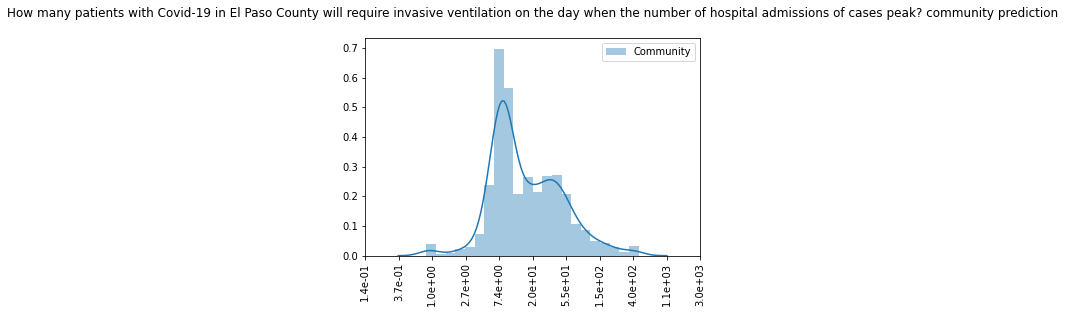

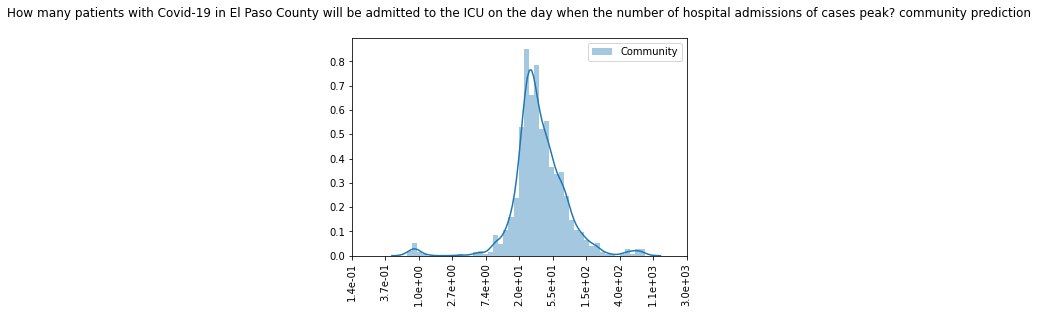



When will El Paso County, Texas, experience its first peak number of COVID infections?



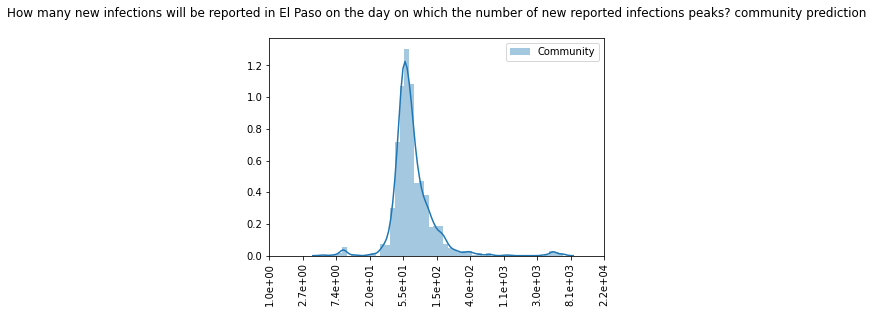

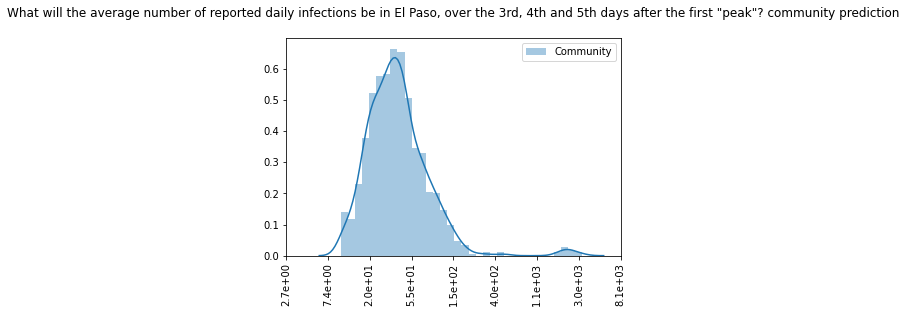

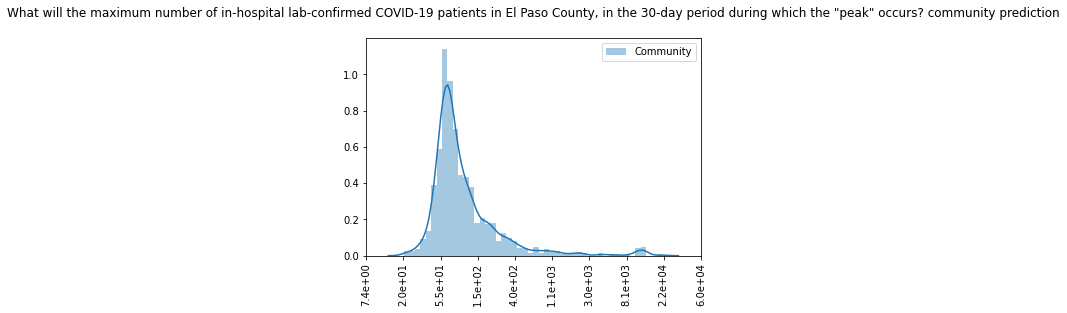

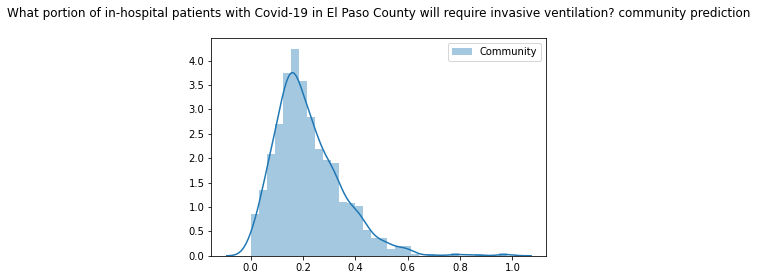

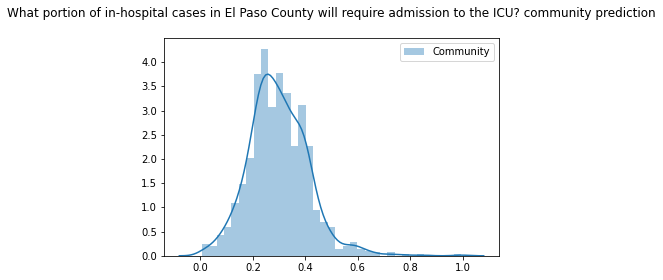

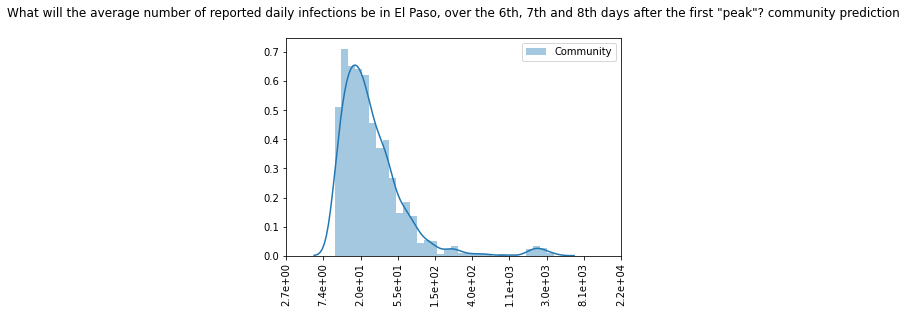

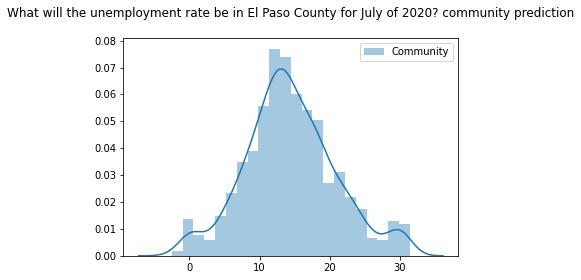

In [6]:
for question in questions:
    question.refresh_question()  # Load detailed question data
    if isinstance(question, ergo.metaculus.LinearDateQuestion):
        print(f"{question}\n")
    else:
        question.show_community_prediction()
        print("\n")